$$
H_s = -\sum_i J s^z_i s^z_{i+1} - \sum_i (h_x s^x_i + h_z s^z_i)
$$
The spins in the system hamiltonian $H_s$ are coupled to bath spins $\sigma_i$ such that the whole hamiltonian is as follows
$$
H = H_s + \sum_{i=1}^L [J_c(t)s_i^z \sigma^z_i - B(t)\sigma_i^z + h_b \sigma_i^x] 
$$
The function $B(t)$ represents the Zeeman field acting on the bath spins and $J_c(t)$ is the strength of the system-bath coupling. The protocol is performed in cycles. The bath spins begin each one in a fully polarized state and are reset at the beginning of a new cycle. 



In [62]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
sns.set_style("whitegrid")



In [63]:
# Pauli matricies

si = qt.qeye(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

In [64]:
end_of_cycle_measurement = False         # Meritev spinov v sigma^z bazi po koncu vsakega cikla
pass_directly_with_added_errors = False 
remake_product_state = False
remake_product_state_LSQ = True
open_dynamics = False          # Odprt sistem z sigma^z collapse operatorji na vsakem spinu
couplings_decrease = True      # Linearno nižanje  sklopitve iz cikla v cikel
coupling = "lin"
hb_decrease = False           #  Linearno nižanje hb polja iz cikla v cikel

In [65]:
#### Simulation parameters ####
dt = 0.1
T = 50.0
times = np.arange(0.0, T+dt, dt)

N_cycles = 30  # Stevilo ciklov algoritma


#### TFIM system parameters ####
L = 6 # length of chain
N = 2*L # total number of sites

J = 1
hx = 0.3
hz = 0

#### Coupling and bath parameters ####
Jc = 0.8
Bi = 4.0
Bf = 0.0

hb = 0.8

tfim_parameters = [J, hx, hz]
bath_parameters = [hb, Bi, Bf, T]
coupling_parameters = [Jc, T]

time_dependant_functions_coeffs = {'Jc': Jc, 'T': T, 'Bi': Bi, 'Bf': Bf}

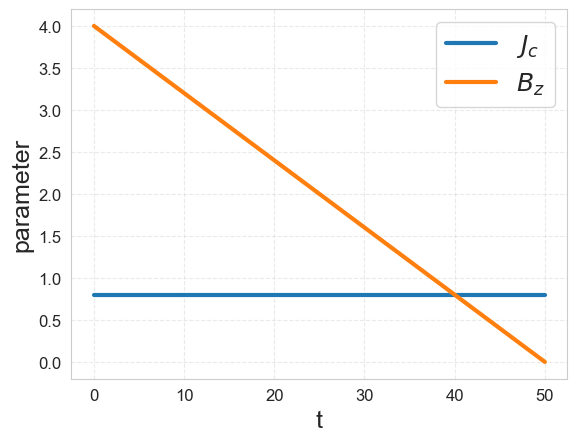

In [66]:
def bath_z_field_zeeman_drive(t, args):
    """Function B(t)"""
    TT = args['T']
    B_i = args['Bi']
    B_f = args['Bf']

    return (((B_f - B_i)/(TT)) * t + B_i)




def coupling_drive(t, args):
    """Function g(t)"""
    TT = args['T']
    J_c = args['Jc']

    return J_c        



plt.plot(times, [coupling_drive(t, time_dependant_functions_coeffs) for t in times], label=r'$J_c$', lw=3.0)
plt.plot(times, bath_z_field_zeeman_drive(times, time_dependant_functions_coeffs), label=r'$B_z$', lw=3.0)
plt.xlabel('t', fontsize = 18)
plt.ylabel('parameter', fontsize = 18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=18)
plt.grid(linestyle='--', alpha=0.4)

In [67]:
#  Open system collapse operators 


def collapse_operators(L, gamma0=0.05):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))


    gamma_list = np.ones(N) * gamma0

    coll_ops = [gamma_list[i] * sz_list[i] for i in range(N)]

    return coll_ops

In [68]:
# Operators

def tfim_sigmax_magnetisation(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    Mx = 0
    
    for n in range(L):
        Mx+=sx_list[n]
    
    return Mx
    


def tfim_magnetisation(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))
    
    M = 0
    
    for n in range(L):
        M+=sz_list[n]
    
    return M

def tfim_magnetisation_x(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))
    
    M = 0
    
    for n in range(L):
        M+=sx_list[n]
    
    return M

def tfim_magnetisation_y(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))
    
    M = 0
    
    for n in range(L):
        M+=sy_list[n]
    
    return M


def bath_magnetisation(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))
    
    M = 0
    
    for n in range(L, 2*L):
        M+=sz_list[n]
    
    return M

def bath_magnetisation_x(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))
    
    M = 0
    
    for n in range(L, 2*L):
        M+=sx_list[n]
    
    return M

def bath_magnetisation_y(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))
    
    M = 0
    
    for n in range(L, 2*L):
        M+=sy_list[n]
    
    return M



def tfim_hamiltonian(L, tfim_params):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    # Ising model hamiltonian construction
    J, hx, hz = tfim_params

    J_list = np.ones(L) * J
    hx_list = np.ones(L) * hx
    hz_list = np.ones(L) * hz

    H_ising_chain = 0

    for n in range(L):
        H_ising_chain += -hx_list[n] * sx_list[n]
        H_ising_chain += -hz_list[n] * sz_list[n]

    for n in range(L):
        H_ising_chain += - J_list[n] * sz_list[n] * sz_list[((n+1)%L)]

    return H_ising_chain


    





In [69]:
def run_cycle(L, tfim_params, bath_params, coupling_params, psi0, tlist):


    sx_list = []
    sy_list = []
    sz_list = []


    N = 2*L

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    # Ising model hamiltonian construction
    J, hx, hz = tfim_params

    J_list = np.ones(L) * J
    hx_list = np.ones(L) * hx
    hz_list = np.ones(L) * hz

    H_ising_chain = 0

    for n in range(L):
        H_ising_chain += -hx_list[n] * sx_list[n]
        H_ising_chain += -hz_list[n] * sz_list[n]

    for n in range(L):
        H_ising_chain += - J_list[n] * sz_list[n] * sz_list[((n+1)%L)]


    # bath x-field hamiltonian construction
    hb, Bi, Bf, T = bath_params

    hb_bath_list = np.ones(L) * hb
    
    H_bath_x_field = 0

    for m in range(L):
        H_bath_x_field += hb_bath_list[m] * sx_list[m+L]


    # bath z-field hamiltonian construction
     
    H_bath_z_field = 0
    
    for m in range(L):
        H_bath_z_field -= sz_list[m+L]


    def bath_z_field_zeeman_drive(t, args):
        """Function B(t)"""
        TT = args['T']
        B_i = args['Bi']
        B_f = args['Bf']

        return (((B_f - B_i)/(TT)) * t + B_i)


    # bath_system coupling hamiltonian construction

    jc, T = coupling_params

    H_coupling = 0
    
    for n in range(L):
        H_coupling += sz_list[n] * sz_list[n+L]

    
    def coupling_drive(t, args):
        """Function Jc(t)"""
        TT = args['T']
        j_c = args['Jc']

        return j_c 

    # Constructing the whole hamiltonian

    time_dependant_functions_coeffs = {'Jc': jc, 'T': T, 'Bi': Bi, 'Bf': Bf}
    
    H = [H_ising_chain, H_bath_x_field, [H_bath_z_field, bath_z_field_zeeman_drive], [H_coupling, coupling_drive]]

    if open_dynamics:
        col_ops = collapse_operators(L)
    else:
        col_ops = []

    # Running the time evolution
    
    result = qt.sesolve(H, psi0, tlist, e_ops=[], args=time_dependant_functions_coeffs, progress_bar = False)

    return result

In [70]:
# calculating the ground state energy of the TFIM

H_TFIM = tfim_hamiltonian(L, tfim_parameters)
M_TFIM = tfim_magnetisation(L)

eigen_energies = H_TFIM.eigenenergies()

E0 = eigen_energies[0]
print("TFIM ground energy: ", E0)

TFIM ground energy:  -6.13594998532749


In [71]:

# Setting up the inital states

bath_fully_polarized_state = qt.tensor([qt.basis(2,0) for i in range(L)])
bath_fully_polarized_density_matrix = bath_fully_polarized_state * bath_fully_polarized_state.dag()

random_tfim_state = qt.tensor([qt.rand_ket(2) for i in range(L)])
neel_state = qt.tensor([qt.basis(2,i%2) for i in range(L)])

inital_state = qt.tensor([neel_state, bath_fully_polarized_state])
#inital_state = qt.tensor([random_tfim_state, bath_fully_polarized_state])





In [72]:
# Setting for the changing of parameters cycle to cycle

if couplings_decrease:
    if coupling == "lin":
        f = lambda i:-0.5*Jc*i/N_cycles + Jc 
    if coupling == "fd":
        epsilon = 10**-3
        b = 1/N_cycles * np.log((2-epsilon)/epsilon)
        f = lambda i: 2/(1+np.exp(b*i))
    
    if coupling == "exp":
        pass

    couplings = [Jc * f(i) for i in range(N_cycles)]

else:
    couplings = [Jc for i in range(N_cycles)]

if hb_decrease:
    hb_fields = [-0.5*hb*i/N_cycles + hb for i in range(N_cycles)]
else:
    hb_fields = [hb for i in range(N_cycles)]


end_of_process_tfim_energies = []
whole_process_energies = []
whole_process_entropies = []
whole_process_tfim_magnetisations = []
whole_process_bath_magnetisations = []
whole_process_tfim_magnetisations_x_direction = []
whole_process_bath_magnetisations_x_direction = []
whole_process_tfim_magnetisations_y_direction = []
whole_process_bath_magnetisations_y_direction = []

# Main loop

for k in tqdm(range(N_cycles)):
    
    coupling_parameters = [couplings[k], T]
    bath_parameters = [hb_fields[k], Bi, Bf, T]

    
    
    cycle_result = run_cycle(L, tfim_parameters, bath_parameters, coupling_parameters, inital_state, times)     # Runing a single cycle
    cycle_states = cycle_result.states
    
    #for i in range(len(cycle_states)):
    #    cycle_states[i] = cycle_states[i] * cycle_states[i].dag()
    
    #print(H_TFIM.shape)
    #print(cycle_states[0].shape)
    # cycle._result.states ne da dejansko samo stanj ven?
    #print(1/0)
    
    cycle_tfim_energy = qt.expect(H_TFIM, cycle_states)
    whole_process_energies.append(cycle_tfim_energy)

    tfim_cycle_states = [st.ptrace([i for i in range(L)]) for st in cycle_states]
    whole_process_entropies.append([qt.entropy_vn(st * st.dag()) for st in tfim_cycle_states])

    whole_process_tfim_magnetisations.append(qt.expect(tfim_magnetisation(L), cycle_states) / L)
    whole_process_tfim_magnetisations_x_direction.append(qt.expect(tfim_magnetisation_x(L), cycle_states) / L)
    whole_process_bath_magnetisations.append(qt.expect(bath_magnetisation(L), cycle_states) / L)
    whole_process_bath_magnetisations_x_direction.append(qt.expect(bath_magnetisation_x(L), cycle_states) / L)

    whole_process_tfim_magnetisations_y_direction.append(qt.expect(tfim_magnetisation_y(L), cycle_states) / L)
    whole_process_bath_magnetisations_y_direction.append(qt.expect(bath_magnetisation_y(L), cycle_states) / L)

    
    end_of_process_tfim_energies.append(cycle_tfim_energy[-1])

    end_cycle_state = cycle_states[-1]
    end_cycle_state = end_cycle_state.tidyup()

    if end_of_cycle_measurement:

        mag, after_measure_state = qt.measurement.measure_observable(end_cycle_state, tfim_magnetisation(L))
        tfim_part_of_the_end_cycle_state_density_matrix = after_measure_state.ptrace([i for i in range(L)])
        tfim_part_of_the_end_cycle_state = qt.Qobj((tfim_part_of_the_end_cycle_state_density_matrix.diag()), dims=[[2 for i in range(L)], [1 for i in range(L)]])

        inital_state = qt.tensor([tfim_part_of_the_end_cycle_state, bath_fully_polarized_state])

    elif remake_product_state: 
        tfim_part_of_the_end_cycle_state_density_matrix = end_cycle_state.ptrace([i for i in range(L)])
        
        from pulses_lib import reconstruct_state_L1
        reconstructed_state = reconstruct_state_L1(tfim_part_of_the_end_cycle_state_density_matrix)

        inital_state = qt.tensor([reconstructed_state, bath_fully_polarized_state])

    elif remake_product_state_LSQ: 
            tfim_part_of_the_end_cycle_state_density_matrix = end_cycle_state.ptrace([i for i in range(L)])
            
            from pulses_lib import reconstruct_state_L1_LSQ
            reconstructed_state = reconstruct_state_L1_LSQ(tfim_part_of_the_end_cycle_state_density_matrix)

            inital_state = qt.tensor([reconstructed_state, bath_fully_polarized_state])

    elif pass_directly_with_added_errors:
        m_part_of_the_end_cycle_state_density_matrix = end_cycle_state.ptrace([i for i in range(L)])
        random_state = qt.tensor([qt.rand_ket(2) for i in range(L)])
        random_state = random_state * random_state.dag()

        keep_amount = 1

        tfim_new = np.sqrt(keep_amount) * m_part_of_the_end_cycle_state_density_matrix + np.sqrt(1-keep_amount) * random_state

        inital_state = qt.tensor([tfim_new, bath_fully_polarized_density_matrix])

    else:

        tfim_part_of_the_end_cycle_state_density_matrix = end_cycle_state.ptrace([i for i in range(L)])
        inital_state = qt.tensor([tfim_part_of_the_end_cycle_state_density_matrix, bath_fully_polarized_density_matrix])



  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\Uporabnik\.conda\envs\IJS2024-Humar_edition\Lib\site-packages\qutip\solver\solver_base.py:434: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(
100%|██████████| 30/30 [45:57<00:00, 91.92s/it]


Text(0.5, 1.0, 'TFIM energies during cycles')

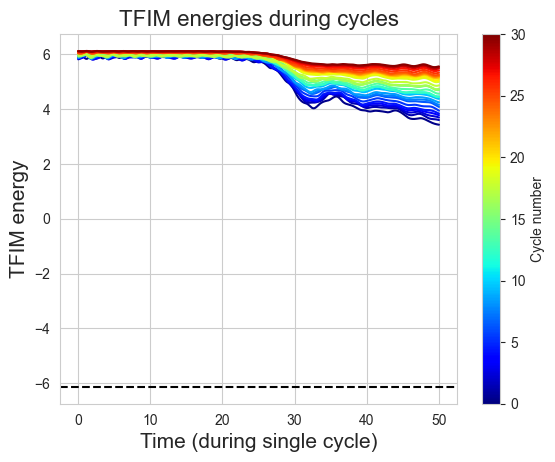

In [73]:
cmap = plt.get_cmap('jet')
COLORS = [cmap(i) for i in np.linspace(.01, .99, N_cycles)]

for i, energ in enumerate(whole_process_energies):
    plt.plot(times, energ, color=COLORS[i])

plt.axhline(y=E0, linestyle='--', color='black', label=r"$E_0$")

norm = mpl.colors.Normalize(vmin=0, vmax=N_cycles)
scalarmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(scalarmappable, ax=plt.gca(), label="Cycle number")

plt.xlabel("Time (during single cycle)", fontsize = 15)
plt.ylabel("TFIM energy", fontsize = 15)
plt.title("TFIM energies during cycles", fontsize = 16) 


Text(0.5, 1.0, 'Entropies during cycles')

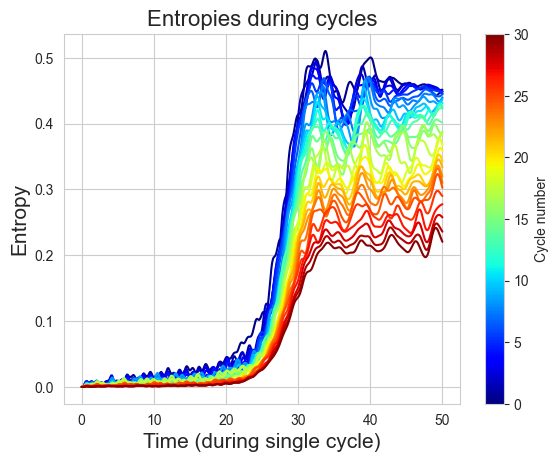

In [74]:
cmap = plt.get_cmap('jet')
COLORS = [cmap(i) for i in np.linspace(.01, .99, N_cycles)]

for i, entrop in enumerate(whole_process_entropies):
    plt.plot(times, entrop, color=COLORS[i])


norm = mpl.colors.Normalize(vmin=0, vmax=N_cycles)
scalarmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(scalarmappable, ax=plt.gca(), label="Cycle number")

plt.xlabel("Time (during single cycle)", fontsize = 15)
plt.ylabel("Entropy", fontsize = 15)
plt.title("Entropies during cycles", fontsize = 16) 

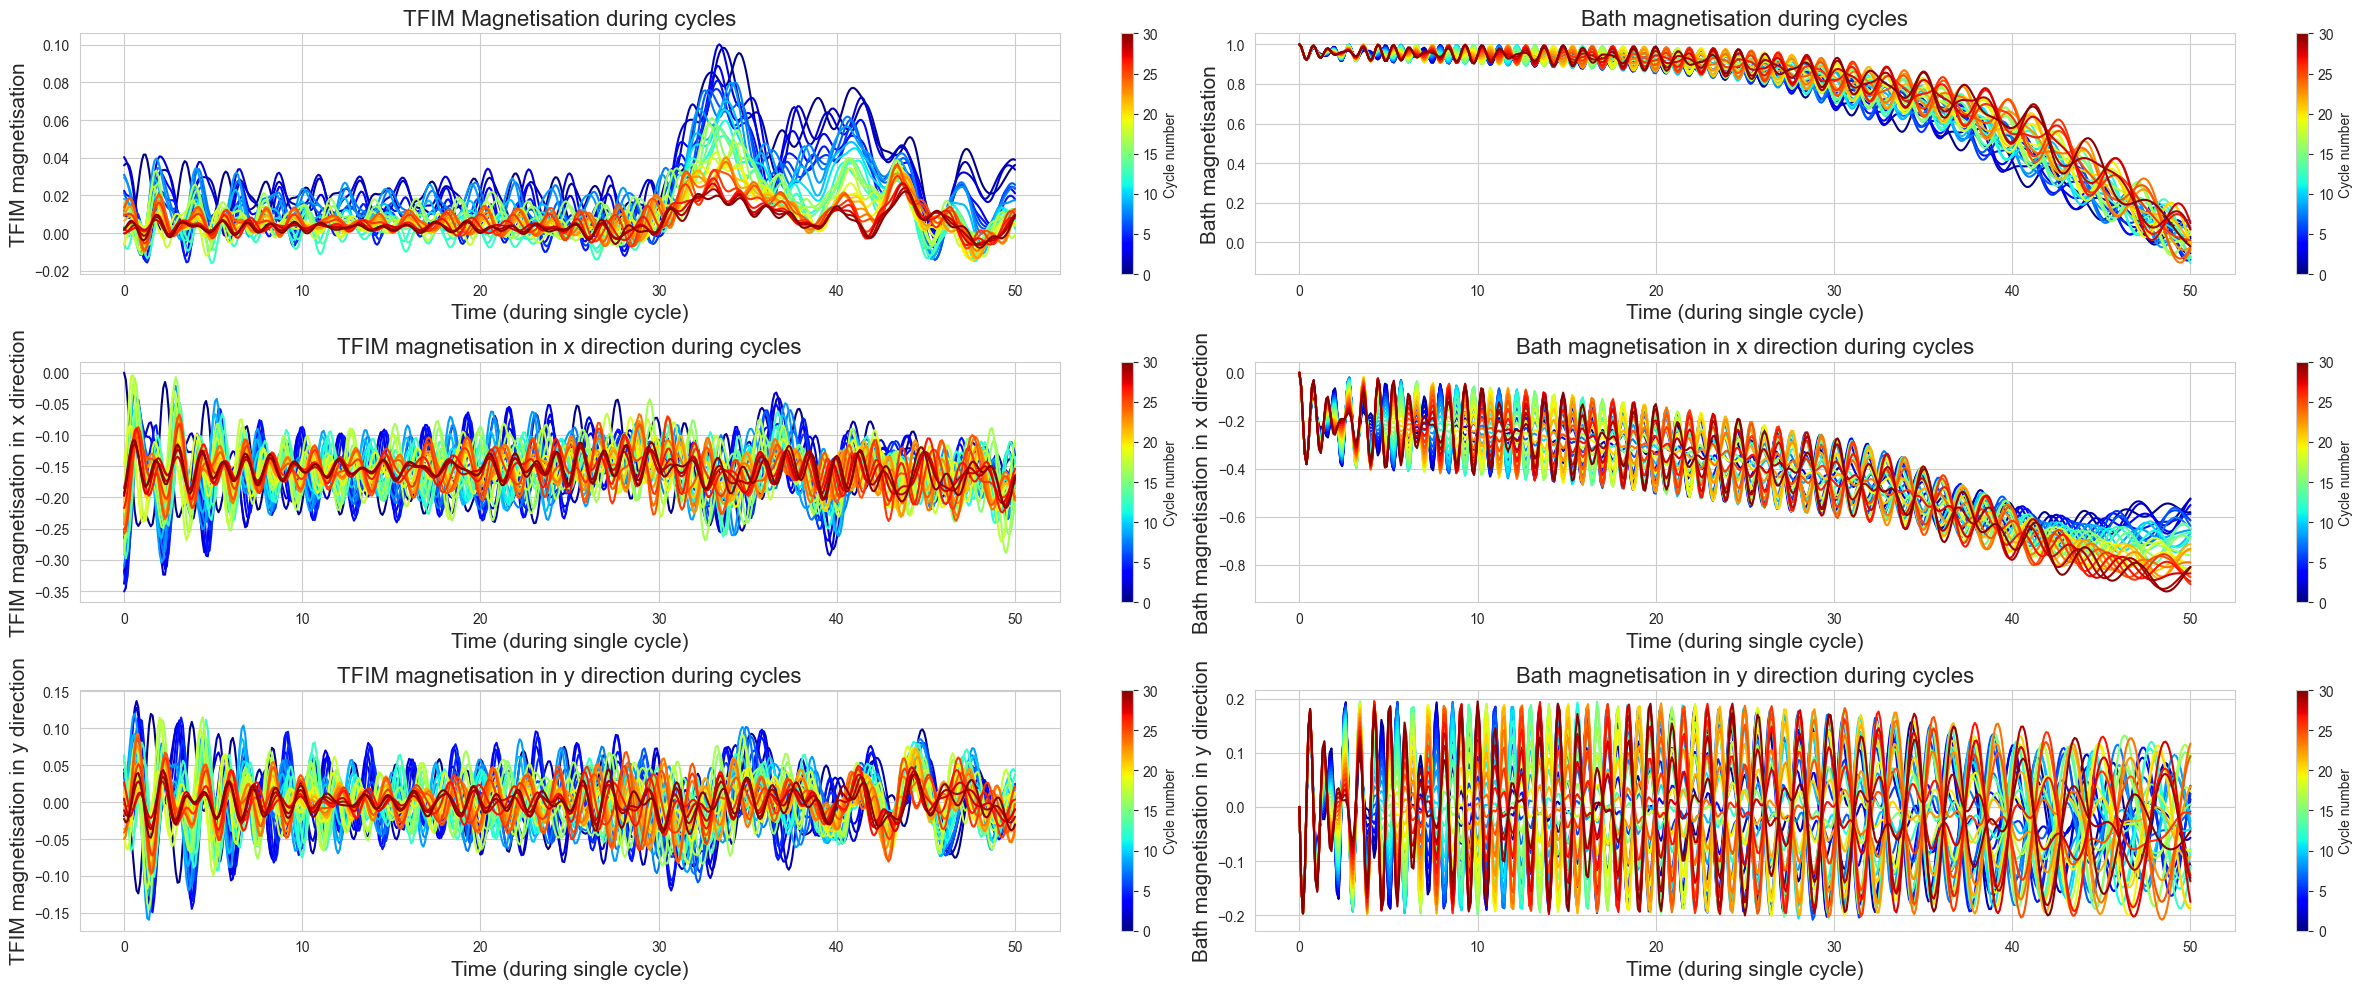

In [75]:
cmap = plt.get_cmap('jet')
COLORS = [cmap(i) for i in np.linspace(.01, .99, N_cycles)]

plt.figure(figsize=(25, 10))

plt.subplot(3, 2, 1)

for i, magnet in enumerate(whole_process_tfim_magnetisations):
    plt.plot(times, magnet, color=COLORS[i])


norm = mpl.colors.Normalize(vmin=0, vmax=N_cycles)
scalarmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(scalarmappable, ax=plt.gca(), label="Cycle number")

plt.xlabel("Time (during single cycle)", fontsize = 15)
plt.ylabel("TFIM magnetisation", fontsize = 15)
plt.title("TFIM Magnetisation during cycles", fontsize = 16) 


plt.subplot(3, 2, 2)

for i, magnet in enumerate(whole_process_bath_magnetisations):
    plt.plot(times, magnet, color=COLORS[i])


norm = mpl.colors.Normalize(vmin=0, vmax=N_cycles)
scalarmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(scalarmappable, ax=plt.gca(), label="Cycle number")

plt.xlabel("Time (during single cycle)", fontsize = 15)
plt.ylabel("Bath magnetisation", fontsize = 15)
plt.title("Bath magnetisation during cycles", fontsize = 16)

plt.tight_layout()

plt.subplot(3, 2, 3)

for i, magnet in enumerate(whole_process_tfim_magnetisations_x_direction):
    plt.plot(times, magnet, color=COLORS[i])


norm = mpl.colors.Normalize(vmin=0, vmax=N_cycles)
scalarmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(scalarmappable, ax=plt.gca(), label="Cycle number")

plt.xlabel("Time (during single cycle)", fontsize = 15)
plt.ylabel("TFIM magnetisation in x direction", fontsize = 15)
plt.title("TFIM magnetisation in x direction during cycles", fontsize = 16)

plt.tight_layout()

plt.subplot(3, 2, 4)

for i, magnet in enumerate(whole_process_bath_magnetisations_x_direction):
    plt.plot(times, magnet, color=COLORS[i])


norm = mpl.colors.Normalize(vmin=0, vmax=N_cycles)
scalarmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(scalarmappable, ax=plt.gca(), label="Cycle number")

plt.xlabel("Time (during single cycle)", fontsize = 15)
plt.ylabel("Bath magnetisation in x direction", fontsize = 15)
plt.title("Bath magnetisation in x direction during cycles", fontsize = 16)


plt.subplot(3, 2, 5)

for i, magnet in enumerate(whole_process_tfim_magnetisations_y_direction):
    plt.plot(times, magnet, color=COLORS[i])


norm = mpl.colors.Normalize(vmin=0, vmax=N_cycles)
scalarmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(scalarmappable, ax=plt.gca(), label="Cycle number")

plt.xlabel("Time (during single cycle)", fontsize = 15)
plt.ylabel("TFIM magnetisation in y direction", fontsize = 15)
plt.title("TFIM magnetisation in y direction during cycles", fontsize = 16)

plt.tight_layout()

plt.subplot(3, 2, 6)

for i, magnet in enumerate(whole_process_bath_magnetisations_y_direction):
    plt.plot(times, magnet, color=COLORS[i])


norm = mpl.colors.Normalize(vmin=0, vmax=N_cycles)
scalarmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(scalarmappable, ax=plt.gca(), label="Cycle number")

plt.xlabel("Time (during single cycle)", fontsize = 15)
plt.ylabel("Bath magnetisation in y direction", fontsize = 15)
plt.title("Bath magnetisation in y direction during cycles", fontsize = 16)

plt.tight_layout()


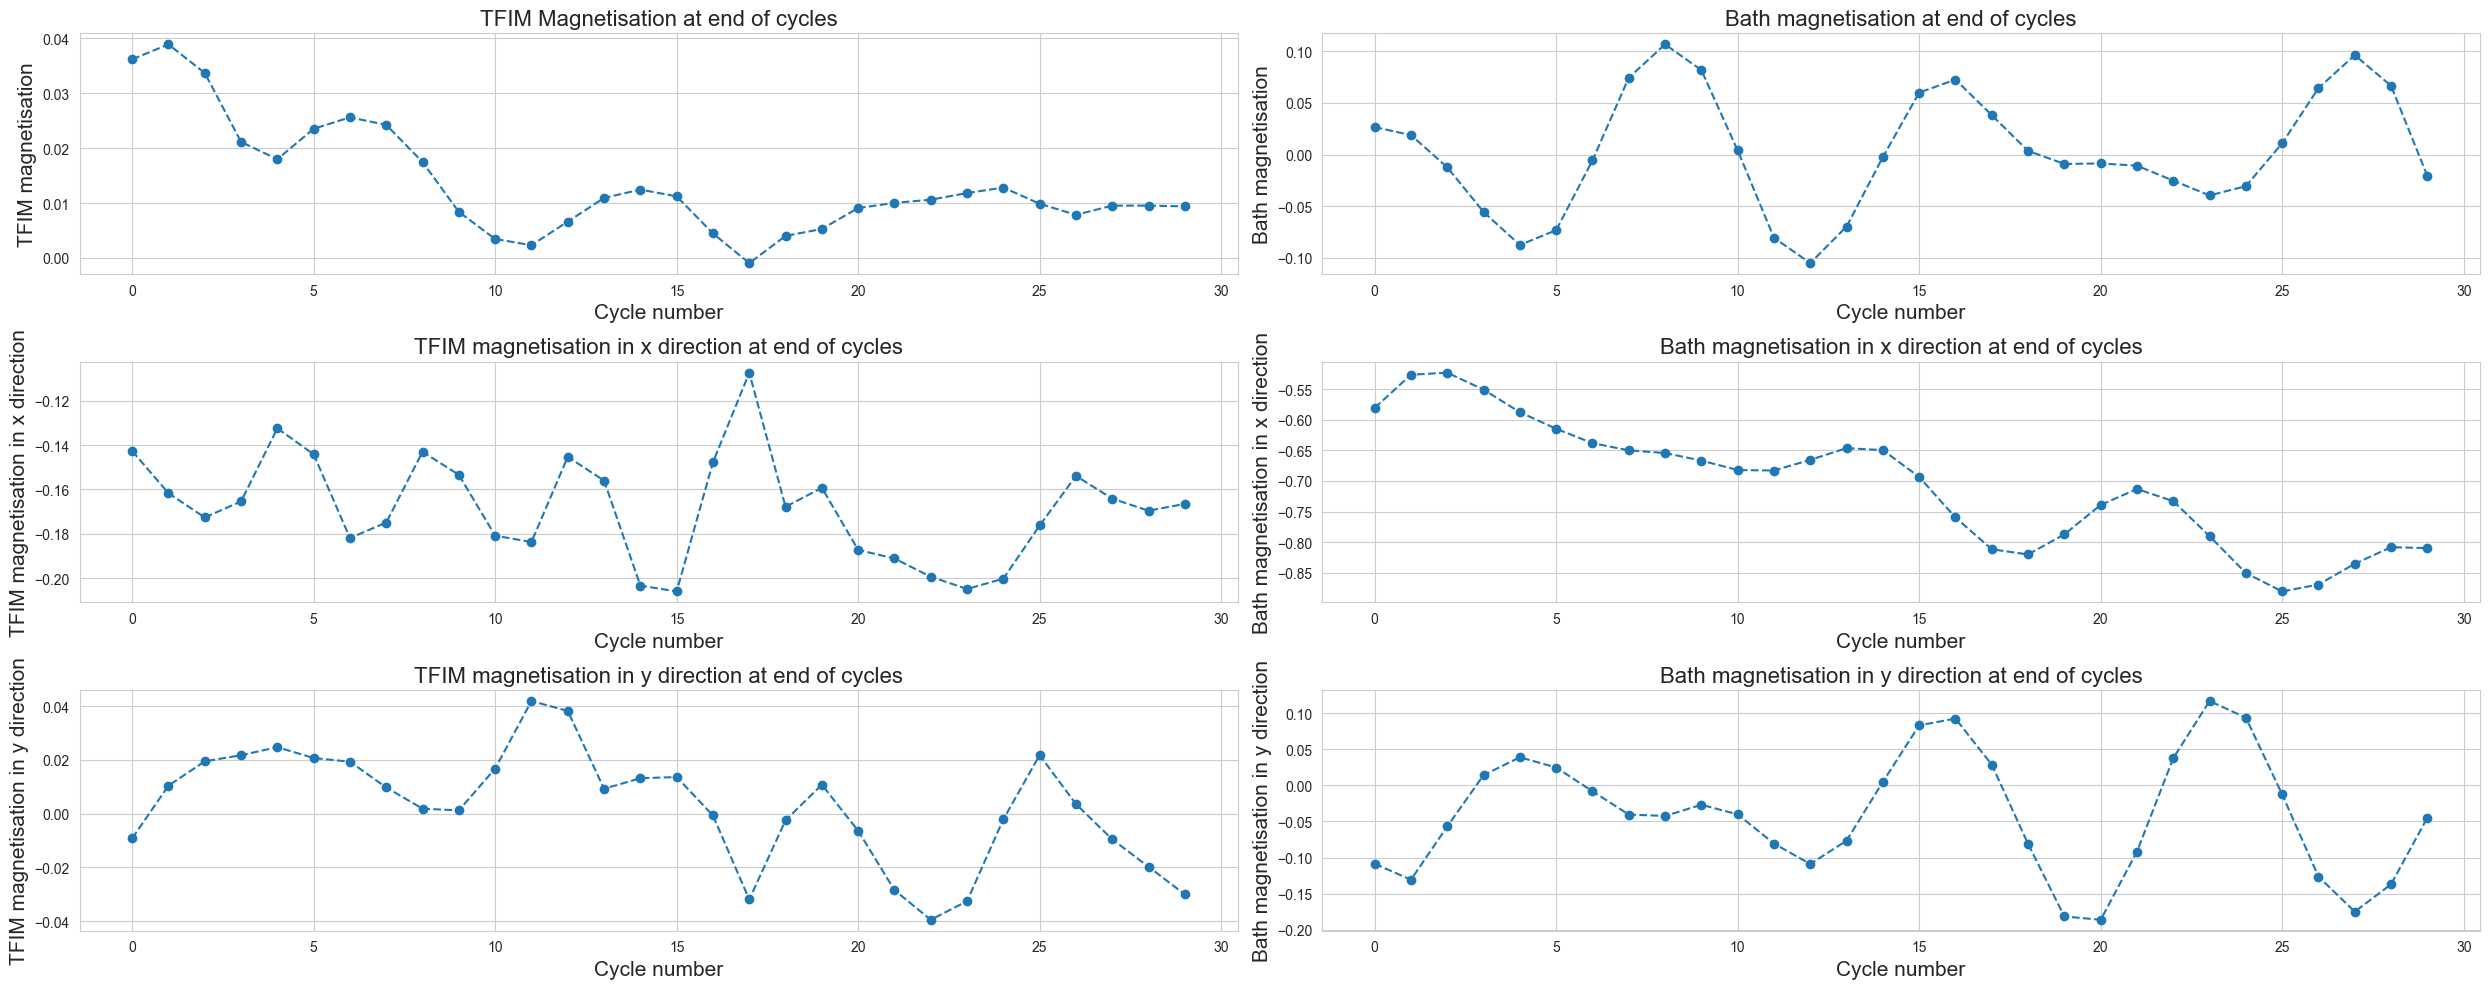

In [76]:
whole_process_tfim_magnetisations = np.array(whole_process_tfim_magnetisations)
whole_process_tfim_magnetisations_x_direction = np.array(whole_process_tfim_magnetisations_x_direction)
whole_process_tfim_magnetisations_y_direction = np.array(whole_process_tfim_magnetisations_y_direction)
whole_process_bath_magnetisations = np.array(whole_process_bath_magnetisations)
whole_process_bath_magnetisations_x_direction = np.array(whole_process_bath_magnetisations_x_direction)
whole_process_bath_magnetisations_y_direction = np.array(whole_process_bath_magnetisations_y_direction)



cmap = plt.get_cmap('jet')
COLORS = [cmap(i) for i in np.linspace(.01, .99, N_cycles)]

plt.figure(figsize=(25, 10))

plt.subplot(3, 2, 1)


plt.plot([i for i in range(len(whole_process_tfim_magnetisations[:,-1]))], whole_process_tfim_magnetisations[:,-1], "--o")


plt.xlabel("Cycle number", fontsize = 15)
plt.ylabel("TFIM magnetisation", fontsize = 15)
plt.title("TFIM Magnetisation at end of cycles", fontsize = 16) 


plt.subplot(3, 2, 2)

plt.plot([i for i in range(len(whole_process_bath_magnetisations[:,-1]))], whole_process_bath_magnetisations[:,-1], "--o")

plt.xlabel("Cycle number", fontsize = 15)
plt.ylabel("Bath magnetisation", fontsize = 15)
plt.title("Bath magnetisation at end of cycles", fontsize = 16)

plt.tight_layout()

plt.subplot(3, 2, 3)

plt.plot([i for i in range(len(whole_process_tfim_magnetisations_x_direction[:,-1]))], whole_process_tfim_magnetisations_x_direction[:,-1], "--o")

plt.xlabel("Cycle number", fontsize = 15)
plt.ylabel("TFIM magnetisation in x direction", fontsize = 15)
plt.title("TFIM magnetisation in x direction at end of cycles", fontsize = 16)

plt.tight_layout()

plt.subplot(3, 2, 4)

plt.plot([i for i in range(len(whole_process_bath_magnetisations_x_direction[:,-1]))], whole_process_bath_magnetisations_x_direction[:,-1], "--o")


plt.xlabel("Cycle number", fontsize = 15)
plt.ylabel("Bath magnetisation in x direction", fontsize = 15)
plt.title("Bath magnetisation in x direction at end of cycles", fontsize = 16)


plt.subplot(3, 2, 5)

plt.plot([i for i in range(len(whole_process_tfim_magnetisations_y_direction[:,-1]))], whole_process_tfim_magnetisations_y_direction[:,-1], "--o")

plt.xlabel("Cycle number", fontsize = 15)
plt.ylabel("TFIM magnetisation in y direction", fontsize = 15)
plt.title("TFIM magnetisation in y direction at end of cycles", fontsize = 16)

plt.tight_layout()

plt.subplot(3, 2, 6)

plt.plot([i for i in range(len(whole_process_bath_magnetisations_y_direction[:,-1]))], whole_process_bath_magnetisations_y_direction[:,-1], "--o")


plt.xlabel("Cycle number", fontsize = 15)
plt.ylabel("Bath magnetisation in y direction", fontsize = 15)
plt.title("Bath magnetisation in y direction at end of cycles", fontsize = 16)

plt.tight_layout()

Text(0.5, 1.0, 'L=6, $\\delta t$=0.1, T=50.0, J=1, $h_x$=0.3, $J_c$=0.8, $B_i$=4.0, $B_f$=0.0, $h_b$=0.8')

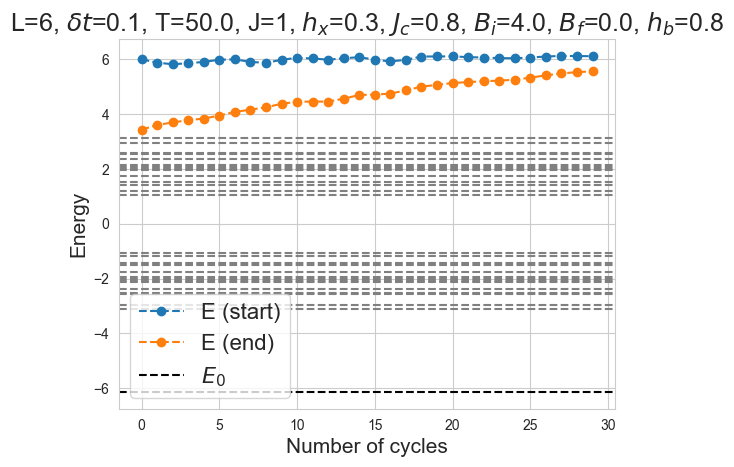

In [77]:
start_cycle_energies = [energ[0] for energ in whole_process_energies]



plt.plot(start_cycle_energies, '--o', label="E (start)")
plt.plot(end_of_process_tfim_energies, '--o', label="E (end)")

plt.axhline(y=E0, linestyle='--', color='black', label=r"$E_0$")

i = 0
j = 0
E = E0
while True:
    try:
        i += 1
        #print(f"{E}  {j}  {i}")
        if eigen_energies[i] > np.max(start_cycle_energies) and eigen_energies[i] > np.max(end_of_process_tfim_energies):
            break
        if np.round(eigen_energies[i], 2) == np.round(E,2):
            continue

        plt.axhline(y=eigen_energies[i], linestyle='--', color='gray')
        j += 1
        E = eigen_energies[i]
    except IndexError:
        break

plt.legend(fontsize = 16)
plt.xlabel('Number of cycles', fontsize = 15)
plt.ylabel('Energy', fontsize = 15)
plt.title(fr'L={L}, $\delta t$={dt}, T={T}, J={J}, $h_x$={hx}, $J_c$={Jc}, $B_i$={Bi}, $B_f$={Bf}, $h_b$={hb}', fontsize = 18) 

Text(0.5, 1.0, 'L=6, $\\delta t$=0.1, T=50.0, J=1, $h_x$=0.3, $J_c$=0.8, $B_i$=4.0, $B_f$=0.0, $h_b$=0.8')

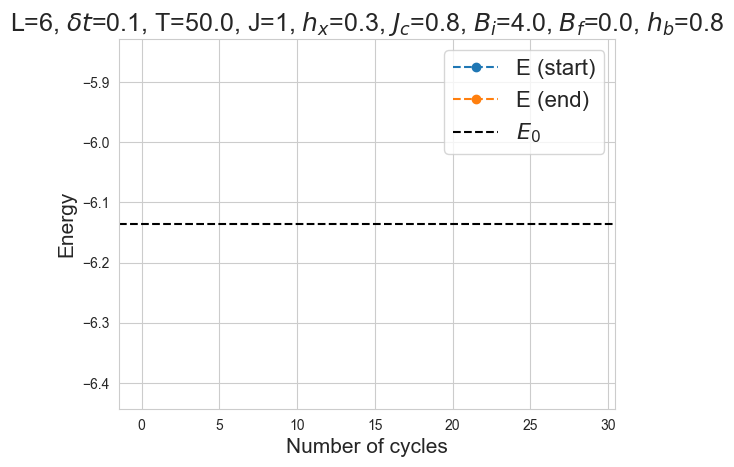

In [78]:
start_cycle_energies = [energ[0] for energ in whole_process_energies]



plt.plot(start_cycle_energies, '--o', label="E (start)")
plt.plot(end_of_process_tfim_energies, '--o', label="E (end)")

plt.axhline(y=E0, linestyle='--', color='black', label=r"$E_0$")

plt.ylim(bottom=E0*(1 + 0.05), top=E0*(1 - 0.05))

plt.legend(fontsize = 16)
plt.xlabel('Number of cycles', fontsize = 15)
plt.ylabel('Energy', fontsize = 15)
plt.title(fr'L={L}, $\delta t$={dt}, T={T}, J={J}, $h_x$={hx}, $J_c$={Jc}, $B_i$={Bi}, $B_f$={Bf}, $h_b$={hb}', fontsize = 18) 